# Association rule-mining for cross-selling
+ [Groceries dataset](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/groceries.csv)
+ [Online retail dataset ](http://archive.ics.uci.edu/ml/datasets/online+retail)

# Load necessary dependencies

In [4]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *

import matplotlib.pyplot as plt
import seaborn as sns

# setting params
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
         'font.size': 18}
%matplotlib inline
plt.rcParams.update(params)

# Construct and load the dataset

In [5]:
grocery_items = set()
with open("grocery_dataset.txt") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        grocery_items.update(line)
output_list = list()
with open("grocery_dataset.txt") as f:
    reader = csv.reader(f, delimiter=",")
    for i, line in enumerate(reader):
        row_val = {item:0 for item in grocery_items}
        row_val.update({item:1 for item in line})
        output_list.append(row_val)
grocery_df = pd.DataFrame(output_list)

In [12]:
grocery_df.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
grocery_df.shape

(9835, 169)

# View top sold items

In [118]:
total_item_count = sum(grocery_df.sum())
print(total_item_count)
item_summary_df = grocery_df.sum().sort_values(
    ascending=False).reset_index().head(n=20)
item_summary_df.rename(
    columns={
        item_summary_df.columns[0]: 'item_name',
        item_summary_df.columns[1]: 'item_count'
    },
    inplace=True)
item_summary_df.head()

43367


,item_name,item_count
0,whole milk,2513
1,other vegetables,1903
2,rolls/buns,1809
3,soda,1715
4,yogurt,1372


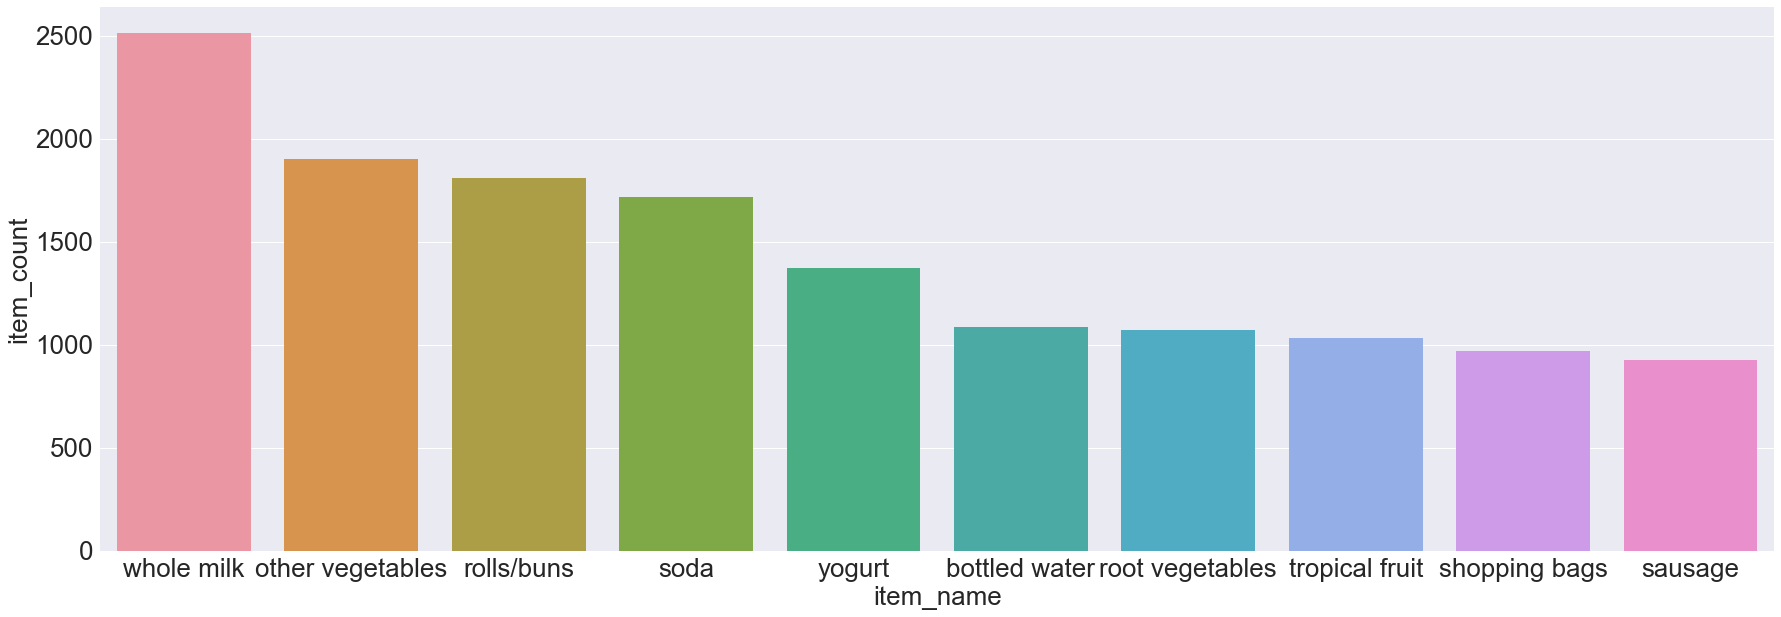

In [161]:
sns.barplot(data=item_summary_df.head(10),x='item_name',y='item_count')
sns.set(rc=params)

## Analyze items contributing to top sales

In [162]:
item_summary_df['item_perc'] = item_summary_df['item_count']/total_item_count
item_summary_df['total_perc'] = item_summary_df.item_perc.cumsum()
item_summary_df.head(20)

,item_name,item_count,item_perc,total_perc
0,whole milk,2513,0.057947,0.057947
1,other vegetables,1903,0.043881,0.101829
2,rolls/buns,1809,0.041714,0.143542
3,soda,1715,0.039546,0.183089
4,yogurt,1372,0.031637,0.214725
5,bottled water,1087,0.025065,0.239791
6,root vegetables,1072,0.024719,0.264510
7,tropical fruit,1032,0.023797,0.288307
8,shopping bags,969,0.022344,0.310651
9,sausage,924,0.021307,0.331957


### Total:
+ top 5 items responsible for 20% of sales
+ top 20 items responsible for 50% of sales
### How this knowledge can help us:
+ not to create association rules for infrequent items
+ keep itemset not too big

# Construct Orange table

In [6]:
input_assoc_rules = grocery_df
domain_grocery = Domain([
    DiscreteVariable.make(name=item, values=['0', '1'])
    for item in input_assoc_rules.columns
])
data_gro_1 = Orange.data.Table.from_numpy(
    domain=domain_grocery, X=input_assoc_rules.values, Y=None)

# Prune dataset for frequently used values

In [7]:
def prune_dataset(input_df,
                  length_trans=2,
                  total_sales_perc=0.5,
                  start_item=None,
                  end_item=None):
    if 'total_items' in input_df.columns:
        del (input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending=False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending=False))
    item_count.rename(
        columns={
            item_count.columns[0]: 'item_name',
            item_count.columns[1]: 'item_count'
        },
        inplace=True)
    if not start_item and not end_item:
        item_count['item_perc'] = item_count['item_count'] / total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(
            item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis=1)
        input_df = input_df[input_df.total_items >= length_trans]
        del (input_df['total_items'])
        return input_df[selected_items], item_count[
            item_count.total_perc < total_sales_perc]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis=1)
        input_df = input_df[input_df.total_items >= length_trans]
        del (input_df['total_items'])
        return input_df[selected_items], item_count[start_item:end_item]

In [8]:
output_df, item_counts = prune_dataset(
    grocery_df, length_trans=2, total_sales_perc=0.4)

In [9]:
print(len(item_counts.item_name.values))
print(item_counts.item_name.values)
print(output_df.shape)

13
['whole milk' 'other vegetables' 'rolls/buns' 'soda' 'yogurt'
 'bottled water' 'root vegetables' 'tropical fruit' 'shopping bags'
 'sausage' 'pastry' 'citrus fruit' 'bottled beer']
(4585, 13)


### Total:
+ 13 items are responsible for 40% of sales
+ 4585 transactions have 2 and more of these items together

# Association Rule Mining with FP Growth

## Prepare table for mining

In [10]:
input_assoc_rules = output_df
domain_grocery = Domain([
    DiscreteVariable.make(name=item, values=['0', '1'])
    for item in input_assoc_rules.columns
])
data_gro_1 = Orange.data.Table.from_numpy(
    domain=domain_grocery, X=input_assoc_rules.values, Y=None)
data_gro_1_en, mapping = OneHot.encode(data_gro_1, include_class=False)

### Check itemsets for support of 1%

In [11]:
min_support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*min_support))
num_trans = input_assoc_rules.shape[0]*min_support
itemsets = dict(frequent_itemsets(data_gro_1_en, min_support=min_support))
len(itemsets)

num of required transactions =  45


166886

## Rule generation and decoding rules

In [12]:
def generate_raw_rules(confidence,itemsets,mapping,data_1):
    rules_df = pd.DataFrame()

    if len(itemsets) < 1000000: 
        rules = [(P, Q, supp, conf)
        for P, Q, supp, conf in association_rules(itemsets, confidence)
           if len(Q) == 1 ]

        names = {item: '{}={}'.format(var.name, val)
            for item, var, val in OneHot.decode(mapping, data_1, mapping)}

        eligible_ante = [v for k,v in names.items() if v.endswith("1")]

        N = input_assoc_rules.shape[0]

        rule_stats = list(rules_stats(rules, itemsets, N))

        rule_list_df = []
        for ex_rule_frm_rule_stat in rule_stats:
            ante = ex_rule_frm_rule_stat[0]            
            cons = ex_rule_frm_rule_stat[1]
            named_cons = names[next(iter(cons))]
            if named_cons in eligible_ante:
                rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
                ante_rule = ', '.join(rule_lhs)
                if ante_rule and len(rule_lhs)>1 :
                    rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                                 'confidence' : ex_rule_frm_rule_stat[3],
                                 'coverage' : ex_rule_frm_rule_stat[4],
                                 'strength' : ex_rule_frm_rule_stat[5],
                                 'lift' : ex_rule_frm_rule_stat[6],
                                 'leverage' : ex_rule_frm_rule_stat[7],
                                 'antecedent': ante_rule,
                                 'consequent':named_cons[:-2] }
                    rule_list_df.append(rule_dict)
        rules_df = pd.DataFrame(rule_list_df)
        print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
        if not rules_df.empty:
            pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
            return pruned_rules_df
        else:
            print("Unable to generate any rule")

In [13]:
pruned_rules_df = generate_raw_rules(0.3,itemsets,mapping,data_gro_1)

Raw rules data frame of 16628 rules generated


## Sorting rules in our Grocery Dataset

In [14]:
(pruned_rules_df[['antecedent','consequent',
                  'support','confidence','lift']].groupby('consequent')
                                                 .max()
                                                 .reset_index()
                                                 .sort_values(['lift', 'support','confidence'],
                                                              ascending=False))

,consequent,antecedent,support,confidence,lift
4,root vegetables,"yogurt, tropical fruit",228,0.463636,2.230611
5,sausage,"shopping bags, rolls/buns",59,0.393162,2.201037
8,tropical fruit,"yogurt, root vegetables",92,0.429907,2.156588
1,citrus fruit,"whole milk, other vegetables, tropical fruit",66,0.333333,2.125637
10,yogurt,"whole milk, tropical fruit",199,0.484211,1.891061
2,other vegetables,"yogurt, whole milk, tropical fruit",228,0.643836,1.826724
6,shopping bags,"soda, sausage",50,0.304878,1.782992
0,bottled water,"yogurt, soda",59,0.333333,1.707635
9,whole milk,"yogurt, tropical fruit",228,0.754098,1.703222
3,rolls/buns,"yogurt, tropical fruit",97,0.522222,1.679095


+ Support of the rule is 228, which means, all the items together appear in 228 transactions in the dataset
+ Confidence of the rule is 46%, which means that 46% of the time the antecedent items occurred we also had the consequent in the transaction (i.e. 46% of times, customers who bought the left side items also bought root vegetables)
+ Lift means that the probability of finding root vegetables in the transactions which have yogurt, whole milk, and tropical fruit is greater than the normal probability of finding root vegetables in the previous transactions (2.23). Lift value of 1 indicates that the probability of occurrence of the antecedent and consequent together are independent of each other

# Association rule mining on our online retail dataset

## Load and Filter Dataset

In [31]:
cs_mba = pd.read_excel(io=r'Online Retail.xlsx')
cs_mba_uk = cs_mba[cs_mba.Country == 'United Kingdom']

In [198]:
cs_mba_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Remove returned item as we are only interested in the buying patterns

In [32]:
cs_mba_uk = cs_mba_uk[~(cs_mba_uk.InvoiceNo.str.contains("C") == True)]
cs_mba_uk = cs_mba_uk[~cs_mba_uk.Quantity<0]

In [200]:
cs_mba_uk.shape

(486286, 8)

In [201]:
cs_mba_uk.InvoiceNo.value_counts().shape

(18786,)

## Build Transaction Dataset

In [33]:
items = list(cs_mba_uk.Description.unique())
grouped = cs_mba_uk.groupby('InvoiceNo')
transaction_level_df_uk = grouped.aggregate(lambda x: tuple(x)).reset_index()[[
    'InvoiceNo', 'Description'
]]

In [203]:
transaction_level_df_uk.head()

,InvoiceNo,Description
0,536365,"(WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET..."
1,536366,"(HAND WARMER UNION JACK, HAND WARMER RED POLKA..."
2,536367,"(ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO..."
3,536368,"(JAM MAKING SET WITH JARS, RED COAT RACK PARIS..."
4,536369,"(BATH BUILDING BLOCK WORD,)"


In [34]:
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level_df_uk.to_dict('records'):
    invoice_num = rec['InvoiceNo']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
tranasction_df = pd.DataFrame(new)
del(tranasction_df[tranasction_df.columns[0]])

In [205]:
tranasction_df.shape

(18786, 4058)

In [206]:
tranasction_df.head()

,3 TIER CAKE TIN GREEN AND CREAM,3 TIER CAKE TIN RED AND CREAM,5 HOOK HANGER MAGIC TOADSTOOL,60 TEATIME FAIRY CAKE CASES,"AIRLINE LOUNGE,METAL SIGN",ALARM CLOCK BAKELIKE GREEN,ALARM CLOCK BAKELIKE IVORY,ALARM CLOCK BAKELIKE ORANGE,ALARM CLOCK BAKELIKE RED,ANTIQUE GLASS DRESSING TABLE POT,...,SET OF 6 RIBBONS COUNTRY STYLE,SNACK TRAY RED VINTAGE DOILY,SET OF 6 RIBBONS PERFECTLY PRETTY,SET OF 6 RIBBONS PARTY,SET 10 CARDS SNOWY ROBIN 17099,SET 10 CARDS SWIRLY XMAS TREE 17104,"LETTER ""U"" BLING KEY RING",CREAM HANGING HEART T-LIGHT HOLDER,BLACK SIL'T SQU CANDLE PLATE,"PAPER CRAFT , LITTLE BIRDIE"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Prune dataset

In [19]:
output_df_uk_n, item_counts_n = prune_dataset(
    input_df=tranasction_df, length_trans=2, start_item=0, end_item=15)
print(output_df_uk_n.shape)

(4961, 15)


In [210]:
output_df_uk_n.head()

,WHITE HANGING HEART T-LIGHT HOLDER,JUMBO BAG RED RETROSPOT,REGENCY CAKESTAND 3 TIER,PARTY BUNTING,LUNCH BAG RED RETROSPOT,ASSORTED COLOUR BIRD ORNAMENT,SET OF 3 CAKE TINS PANTRY DESIGN,NATURAL SLATE HEART CHALKBOARD,LUNCH BAG BLACK SKULL.,HEART OF WICKER SMALL,JUMBO BAG PINK POLKADOT,JUMBO SHOPPER VINTAGE RED PAISLEY,JUMBO STORAGE BAG SUKI,PACK OF 72 RETROSPOT CAKE CASES,PAPER CHAIN KIT 50'S CHRISTMAS
12,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0
14,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
16,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
21,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


## Association Rule Mining with FP Growth

In [35]:
input_assoc_rules = output_df_uk_n
domain_transac = Domain([
    DiscreteVariable.make(name=item, values=['0', '1'])
    for item in input_assoc_rules.columns
])
data_tran_uk = Orange.data.Table.from_numpy(
    domain=domain_transac, X=input_assoc_rules.values, Y=None)
data_tran_uk_en, mapping_ret = OneHot.encode(data_tran_uk, include_class=True)

In [36]:
support = 0.01
print("num of required transactions = ",
      int(input_assoc_rules.shape[0] * support))
num_trans = input_assoc_rules.shape[0] * support
itemsets_ret = dict(frequent_itemsets(data_tran_uk_en, support))
print(len(itemsets_ret))

num of required transactions =  49
645632


In [37]:
pruned_rules_df_ret = generate_raw_rules(0.3,itemsets_ret,mapping_ret,data_tran_uk)

Raw rules data frame of 117464 rules generated


## Sort and display rules

In [39]:
dw = pd.options.display.max_colwidth
pd.options.display.max_colwidth = 100
(pruned_rules_df_ret[['antecedent','consequent',
                  'support','confidence','lift']].groupby('consequent')
                                                 .max()
                                                 .reset_index()
                                                 .sort_values(['lift', 'support','confidence'],
                                                              ascending=False)).head(5)

,consequent,antecedent,support,confidence,lift
8,PACK OF 72 RETROSPOT CAKE CASES,"WHITE HANGING HEART T-LIGHT HOLDER, REGENCY CAKESTAND 3 TIER, NATURAL SLATE HEART CHALKBOARD",145,0.971014,5.394404
9,PAPER CHAIN KIT 50'S CHRISTMAS,"WHITE HANGING HEART T-LIGHT HOLDER, REGENCY CAKESTAND 3 TIER, NATURAL SLATE HEART CHALKBOARD",94,0.597701,4.341428
3,JUMBO SHOPPER VINTAGE RED PAISLEY,"WHITE HANGING HEART T-LIGHT HOLDER, PAPER CHAIN KIT 50'S CHRISTMAS",384,0.879310,4.218819
5,LUNCH BAG BLACK SKULL.,"WHITE HANGING HEART T-LIGHT HOLDER, PACK OF 72 RETROSPOT CAKE CASES, LUNCH BAG RED RETROSPOT",227,0.852459,4.078157
4,JUMBO STORAGE BAG SUKI,"WHITE HANGING HEART T-LIGHT HOLDER, SET OF 3 CAKE TINS PANTRY DESIGN , JUMBO BAG PINK POLKADOT",405,0.852459,4.016191
